# Analysis of MD2NMR

Here we investigate effect of max-match and num-matches and evaluate the accuracy with respect to observed values.

In [1]:
import sys, os, re, glob, multiprocessing, argparse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
sys.path.append("/home/dkoes/git/MD2NMR/")
import shiftres,shifts
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Load observed values

In [2]:
observed = dict()
for fname in glob.glob('*.obs.csv'):
    (prot,_,_) = fname.split('.')
    observed[prot] = dict()
    for line in open(fname):
        (rname,rid,N,H,C) = line.split(',')
        observed[prot][int(rid)] = tuple(map(float,(N,H,C)))

In [3]:
prots = [f.split('/')[-1] for f in glob.glob('benchmark/*')]

In [4]:
ffs = [f.split('/')[-1] for f in glob.glob('benchmark/1enh/*')]

In [5]:
def calc_error(obs,calc):
    '''Compute RMSD between two dictionaries mapping resid -> CHN'''
    Ndiff = np.array([ obs[v][0]-calc[v][0] for v in sorted(obs.keys())])
    Hdiff = np.array([ obs[v][1]-calc[v][1] for v in sorted(obs.keys())])
    Cdiff = np.array([ obs[v][2]-calc[v][2] for v in sorted(obs.keys())])
    Nerr = np.sqrt(np.mean(np.square(Ndiff)))
    Herr = np.sqrt(np.mean(np.square(Hdiff)))
    Cerr = np.sqrt(np.mean(np.square(Cdiff)))
    return (Nerr,Herr,Cerr)

In [6]:
def load_shifts(fname):
    ret = dict()
    for line in open(fname):
        if not line.startswith('#'):
            (rid, rname, N,H,C,_,_,_,_) = line.split()
            ret[int(rid)] = tuple(map(float,(N,H,C)))
    return ret

Have precalculated shifts for all trajectories.  Load these in, average, and compute error for every protein/forcefield.

In [7]:
errors = dict()
errors['default'] = dict() #selct top
errors['0.2_1'] = dict() #select top within 0.2
errors['0.2_5'] = dict() #select top 5 within 0.2
errors['5'] = dict() #select top 5
errors['10'] = dict() #select top 5


for ff in ffs:
    for k in errors.keys():
        errors[k][ff] = dict()
    for prot in prots:
        if prot in observed: #skip 1l2y since it only has H
            for k in errors.keys():
                errors[k][ff][prot] = []
            for fname in glob.glob('benchmark/%s/%s/*.shifts'%(prot,ff)):
                shifts = load_shifts(fname)
                if fname.endswith('_0.2_1.shifts'):
                    err = errors['0.2_1']
                elif fname.endswith('_0.2_5.shifts'):
                    err = errors['0.2_5']
                elif fname.endswith('__5.shifts'):
                    err = errors['5']
                elif fname.endswith('__10.shifts'):
                    err = errors['10']                    
                else:
                    err = errors['default']
                err[ff][prot].append(calc_error(observed[prot],shifts))

In [8]:
aveerrors = dict()
for k in errors.keys():
    aveerrors[k] = dict()
    for ff in errors[k]:
        aveerrors[k][ff] = dict()
        for prot in errors[k][ff]:
            aveerrors[k][ff][prot] = np.mean(errors[k][ff][prot],axis=0)

In [9]:
#ave across proteins
protave = dict()
for k in aveerrors.keys():
    protave[k] = dict()
    for ff in aveerrors[k]:
        protave[k][ff] = np.mean(aveerrors[k][ff].values(),axis=0)

In [10]:
#ave across forcefields
totave = dict()
for k in protave.keys():
    totave[k] = np.mean(protave[k].values(),axis=0)

In [11]:
totave

{'0.2_1': array([ 6.38392731,  1.67898114,  2.05287635]),
 '0.2_5': array([ 6.36494081,  1.68040514,  2.02206865]),
 '10': array([ 6.1141772 ,  1.65618606,  1.97446706]),
 '5': array([ 6.10765312,  1.65420947,  1.98066241]),
 'default': array([ 6.1919454 ,  1.65603785,  2.04131587])}

**Conclusion**: Taking the five best matches does slightly better than only the top match, but imposing a cutoff does not help.

In [12]:
Nerr = []
Herr = []
Cerr = []
labels = []
fforder=['ff94','ff96','ff99SB','ff99SBildn','ff99SBnmr','ff03','ff14SB','ff14ipq','ff15ipq']
for ff in fforder:
    labels.append(ff)
    Nerr.append(np.vstack(aveerrors['default'][ff].values())[:,0])
    Herr.append(np.vstack(aveerrors['default'][ff].values())[:,1])
    Cerr.append(np.vstack(aveerrors['default'][ff].values())[:,2])

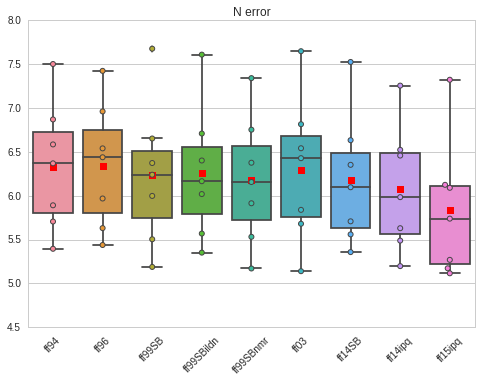

In [13]:
sns.set_style('whitegrid')

sns.boxplot(data=Nerr,showmeans=True)
sns.swarmplot(data=Nerr,linewidth=1)
plt.xticks(xrange(len(labels)),labels,rotation=45);
plt.title('N error');

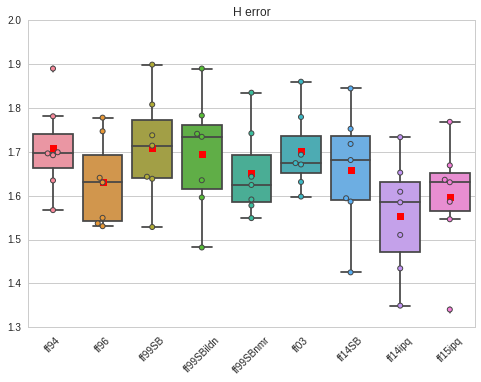

In [14]:
sns.boxplot(data=Herr,showmeans=True)
sns.swarmplot(data=Herr,linewidth=1)
plt.xticks(xrange(len(labels)),labels,rotation=45);
plt.title('H error');

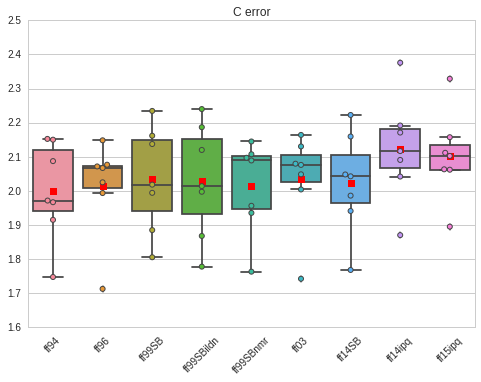

In [15]:
sns.boxplot(data=Cerr,showmeans=True)
sns.swarmplot(data=Cerr,linewidth=1)
plt.xticks(xrange(len(labels)),labels,rotation=45);
plt.title('C error');

In [16]:
data = pd.DataFrame(columns=['ff','prot','N','H','C'])
for ff in errors['5'].iterkeys():
    for prot in errors['5'][ff].iterkeys():
        for (N,H,C) in errors['5'][ff][prot]:
            data.loc[len(data)] = [ff,prot,N,H,C]

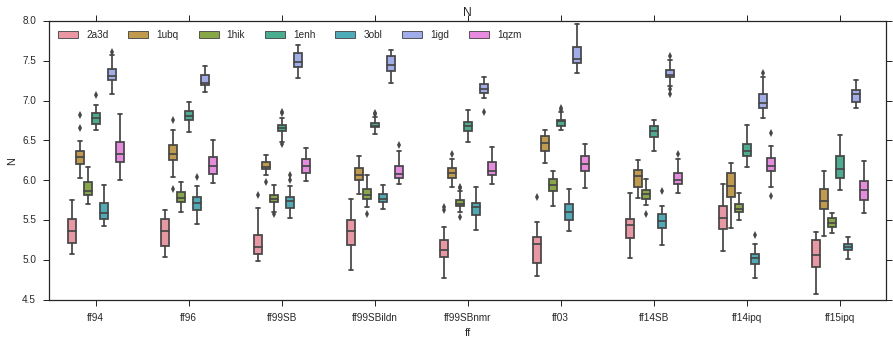

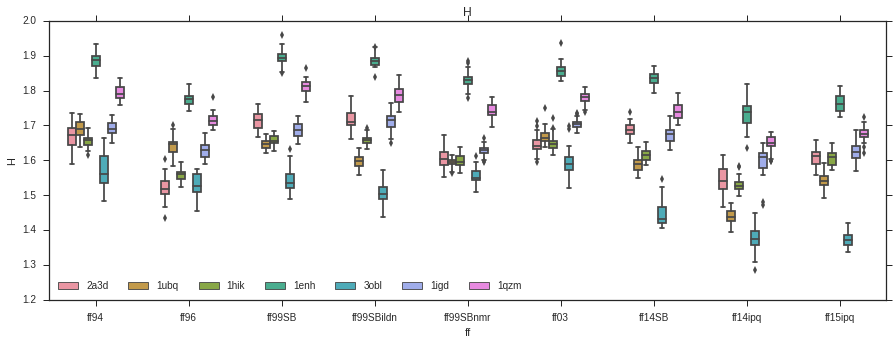

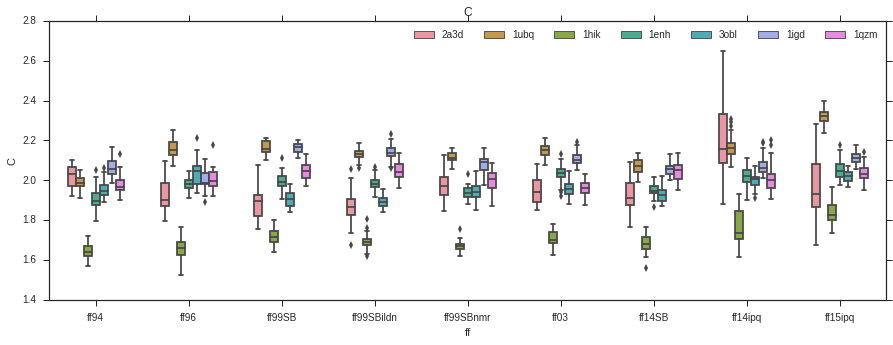

In [17]:
for S in ['N','H','C']:
    plt.figure(figsize=(15,5))
    sns.set(style="ticks")
    sns.boxplot(x='ff',y=S,hue='prot',data=data,width=.6,order=fforder)
    plt.legend(loc='best',ncol=7)
    plt.title(S)
    plt.show()

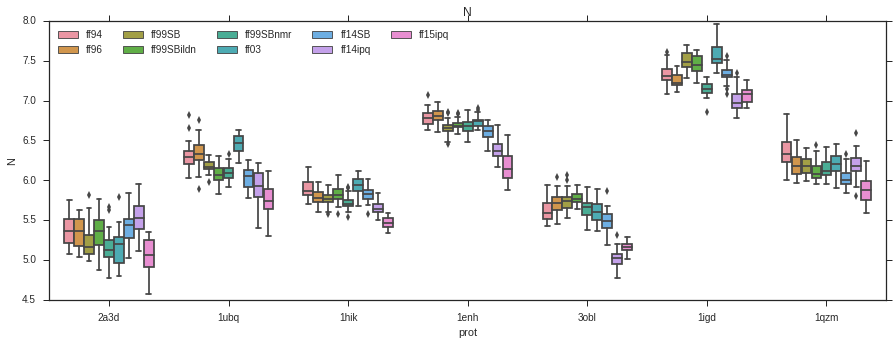

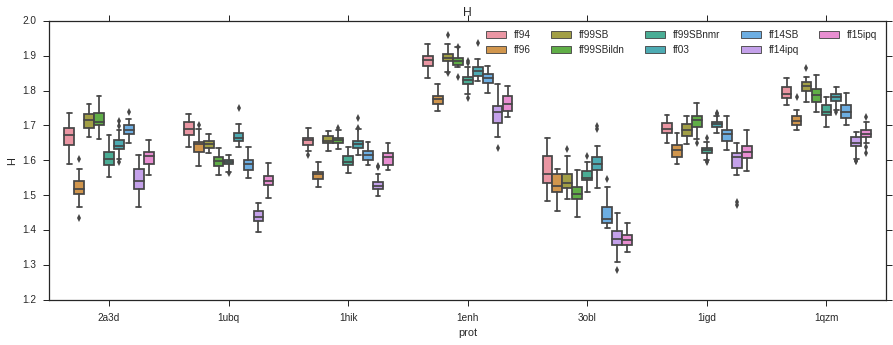

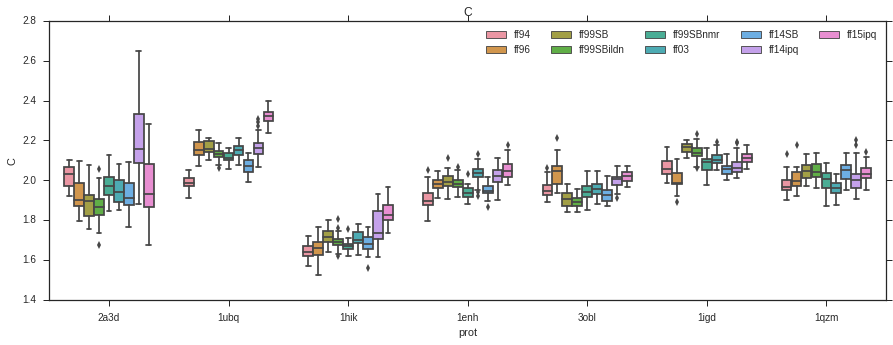

In [18]:
for S in ['N','H','C']:
    plt.figure(figsize=(15,5))
    sns.set(style="ticks")
    sns.boxplot(x='prot',y=S,hue='ff',data=data,width=.75,hue_order=fforder)
    plt.legend(loc='best',ncol=5)
    plt.title(S)
    plt.show()

In [21]:
data.columns

Index([u'ff', u'prot', u'N', u'H', u'C'], dtype='object')

In [31]:
ff94 = data.loc[data['ff'] == 'ff94'].groupby(['prot']).mean()

In [36]:
ff94.loc['1enh'].N

6.783741651145764

In [144]:
data['Nnorm'] = 100*data.N.subtract(ff94.loc[data.prot].N.values)/ff94.loc[data.prot].N.values
data['Cnorm'] = 100*data.C.subtract(ff94.loc[data.prot].C.values)/ff94.loc[data.prot].C.values
data['Hnorm'] = 100*data.H.subtract(ff94.loc[data.prot].H.values)/ff94.loc[data.prot].H.values

In [145]:
normdata = data.groupby(['ff','prot']).mean().reset_index()
normdata['ff'] = pd.Categorical(normdata['ff'],categories=fforder)
normdata=normdata.sort_values(by='ff');

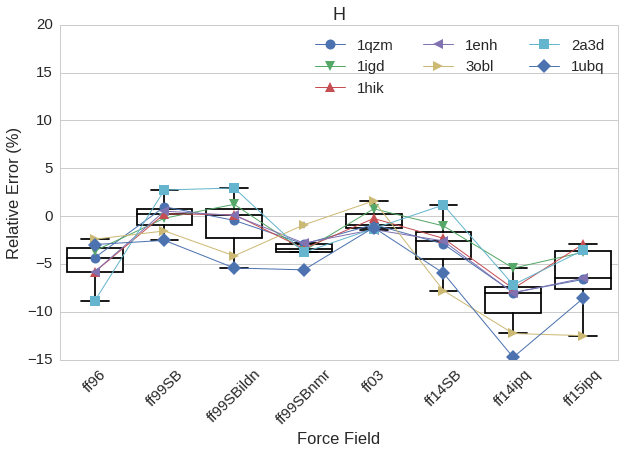

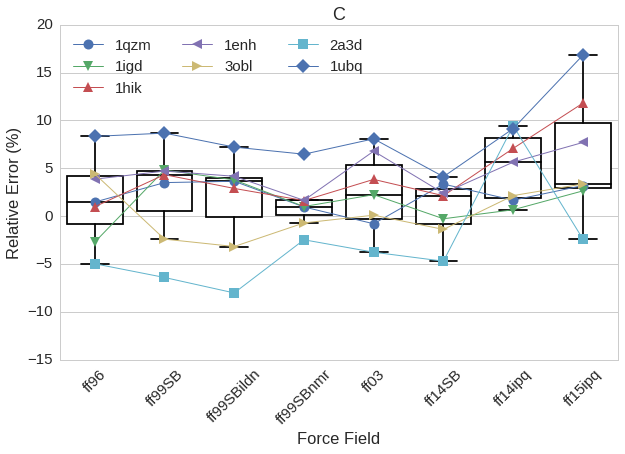

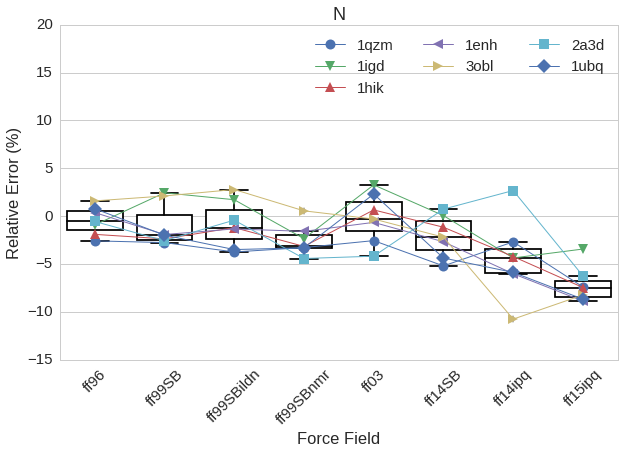

In [209]:
def summary_plot(name):
    plt.figure(figsize=(10,6))
    sns.set(font_scale=1.5)
    sns.set_style('whitegrid')
    ax = sns.boxplot(data=normdata,x='ff',y=name,order=fforder[1:],color='white')
    for box in ax.artists:
        box.set_edgecolor('k')
    for line in ax.lines:
        line.set_color('k')
    #sns.swarmplot(data=normdata,x='ff',y='Hnorm',linewidth=1,order=fforder[1:])
    prots = normdata.prot.unique()
    markers=['o','v','^','<','>','s','D','*','|','X']
    for (i,p) in enumerate(prots):
        pdata = normdata[normdata['prot']==p][name]
        plt.plot(xrange(len(pdata)-1),pdata[1:],'-'+markers[i],label=p,markersize=10,linewidth=1)
    plt.legend(loc='best',ncol=3)
    plt.ylabel("Relative Error (%)")
    plt.xlabel("Force Field")
    plt.xticks(rotation=45)
    plt.ylim(-15,20)
    plt.title(name[0])
    plt.savefig(name+'.pdf')
    
    
summary_plot('Hnorm')
summary_plot('Cnorm')
summary_plot('Nnorm')

In [210]:
data

,ff,prot,N,H,C,Nnorm,Cnorm,Hnorm
0,ff99SBildn,2a3d,5.215080,1.703392,1.905322,-2.982053,-5.785366,2.131131
1,ff99SBildn,2a3d,5.513144,1.712724,1.674634,2.562937,-17.192469,2.690661
2,ff99SBildn,2a3d,5.618164,1.722152,1.883978,4.516647,-6.840801,3.255925
3,ff99SBildn,2a3d,5.392799,1.698837,1.903770,0.324101,-5.862101,1.858000
4,ff99SBildn,2a3d,5.425594,1.708614,1.929932,0.934197,-4.568458,2.444221
5,ff99SBildn,2a3d,5.483725,1.705841,1.877123,2.015636,-7.179750,2.277965
6,ff99SBildn,2a3d,4.868096,1.697007,1.775632,-9.437131,-12.198312,1.748307
7,ff99SBildn,2a3d,5.575111,1.752029,1.903631,3.715730,-5.868954,5.047284
8,ff99SBildn,2a3d,5.113141,1.680733,1.738188,-4.878468,-14.049811,0.772537
9,ff99SBildn,2a3d,5.117501,1.709396,1.853777,-4.797353,-8.334147,2.491127


In [128]:
normdata[normdata['prot']=='1enh'].Hnorm

28   -2.960595e-16
35   -1.095427e-01
42    9.800269e-03
49    1.372604e-03
56   -5.318301e-02
0    -2.634785e-02
7    -4.893108e-02
14   -1.511277e-01
21   -1.222488e-01
Name: Hnorm, dtype: float64

In [115]:
normdata.sort('ff')

/raid/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,ff,prot,N,H,C,Nnorm,Cnorm,Hnorm
31,ff94,1qzm,6.358348,1.793416,1.975090,-5.652044e-16,6.728624e-18,3.229740e-16
30,ff94,1igd,7.318467,1.689671,2.060906,1.399554e-15,3.229740e-16,6.728624e-18
29,ff94,1hik,5.898980,1.654540,1.644288,1.345725e-15,1.009294e-16,3.229740e-16
28,ff94,1enh,6.783742,1.883650,1.906380,-9.150929e-16,-6.728624e-17,-2.960595e-16
34,ff94,3obl,5.621435,1.567967,1.955626,1.399554e-15,-1.749442e-16,4.239033e-16
33,ff94,2a3d,5.375377,1.667848,2.022321,1.130409e-15,-1.480297e-16,4.239033e-16
32,ff94,1ubq,6.300928,1.688930,1.988474,6.728624e-16,-2.893308e-16,-2.018587e-16
35,ff96,1enh,6.809065,1.774108,1.980013,2.532373e-02,7.363314e-02,-1.095427e-01
36,ff96,1hik,5.786578,1.557977,1.660366,-1.124017e-01,1.607837e-02,-9.656336e-02
37,ff96,1igd,7.250752,1.628320,2.004727,-6.771564e-02,-5.617837e-02,-6.135106e-02
